In [1]:
# Load all depths and calculate mean metrics across all runs for each depth
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))

import pickle
import numpy as np

results_dir = '../results_losses_gauss'

# Define depths and loss types to analyze
depths = [1, 2, 3, 4, 5, 6, 7, 8]
# loss_types = ['trace_distance', 'hilbert_schmidt', 'inner_loss']
loss_types = ['trace_distance', 'inner_loss']
depth_loss_results = {}

for depth in depths:
    depth_loss_results[depth] = {}
    
    for loss_type in loss_types:
        # Filter TQFM pickle files for this depth and loss type
        pattern = f'tqfm_{loss_type}_depth{depth}_'
        tqfm_files = [f for f in os.listdir(results_dir) if f.endswith('.pkl') and pattern in f]
        
        if not tqfm_files:
            print(f"No files found for depth {depth}, loss {loss_type}")
            continue
        
        # Load all models for this depth and loss type
        models_data = []
        for tqfm_file in sorted(tqfm_files):
            try:
                with open(os.path.join(results_dir, tqfm_file), 'rb') as f:
                    tqfm = pickle.load(f)
                    
                    # Skip if best_params is None
                    if tqfm.best_params is None:
                        print(f"  Skipping {tqfm_file}: best_params is None")
                        continue
                    
                    final_loss = tqfm.loss_history[-1] if len(tqfm.loss_history) > 0 else None
                    train_acc = tqfm.train_accuracy_history[-1] if tqfm.train_accuracy_history else None
                    
                    if final_loss is not None and train_acc is not None:
                        models_data.append({
                            'tqfm': tqfm,
                            'file': tqfm_file,
                            'loss': final_loss,
                            'train_acc': train_acc
                        })
            except Exception as e:
                print(f"  Error loading {tqfm_file}: {e}")
        
        if models_data:
            # Calculate mean metrics across all valid runs
            mean_loss = np.mean([m['loss'] for m in models_data])
            std_loss = np.std([m['loss'] for m in models_data])
            mean_train_acc = np.mean([m['train_acc'] for m in models_data])
            std_train_acc = np.std([m['train_acc'] for m in models_data])
            
            depth_loss_results[depth][loss_type] = {
                'mean_loss': mean_loss,
                'std_loss': std_loss,
                'mean_train_acc': mean_train_acc,
                'std_train_acc': std_train_acc,
                'n_runs': len(models_data),
                'models': models_data
            }
            
            print(f"Depth {depth}, {loss_type}: {len(models_data)} valid runs")
            print(f"  Mean Loss: {mean_loss:.6f} ± {std_loss:.6f}")
            print(f"  Mean Train Acc: {mean_train_acc:.4f} ± {std_train_acc:.4f}")

print(f"\nTotal depths analyzed: {len(depth_loss_results)}")
print(f"Loss types: {loss_types}")

Depth 1, trace_distance: 20 valid runs
  Mean Loss: 0.429131 ± 0.039410
  Mean Train Acc: 0.9525 ± 0.0310
  Skipping tqfm_inner_loss_depth1_ansatzRealAmplitudes_iter5000_run10.pkl: best_params is None
  Skipping tqfm_inner_loss_depth1_ansatzRealAmplitudes_iter5000_run12.pkl: best_params is None
  Skipping tqfm_inner_loss_depth1_ansatzRealAmplitudes_iter5000_run13.pkl: best_params is None
  Skipping tqfm_inner_loss_depth1_ansatzRealAmplitudes_iter5000_run3.pkl: best_params is None
  Skipping tqfm_inner_loss_depth1_ansatzRealAmplitudes_iter5000_run7.pkl: best_params is None
  Skipping tqfm_inner_loss_depth1_ansatzRealAmplitudes_iter5000_run8.pkl: best_params is None
  Skipping tqfm_inner_loss_depth1_ansatzRealAmplitudes_iter5000_run9.pkl: best_params is None
Depth 1, inner_loss: 13 valid runs
  Mean Loss: 0.340174 ± 0.039069
  Mean Train Acc: 0.8231 ± 0.0489
Depth 2, trace_distance: 20 valid runs
  Mean Loss: 0.358975 ± 0.029853
  Mean Train Acc: 0.9475 ± 0.0167
Depth 2, inner_loss: 20 v

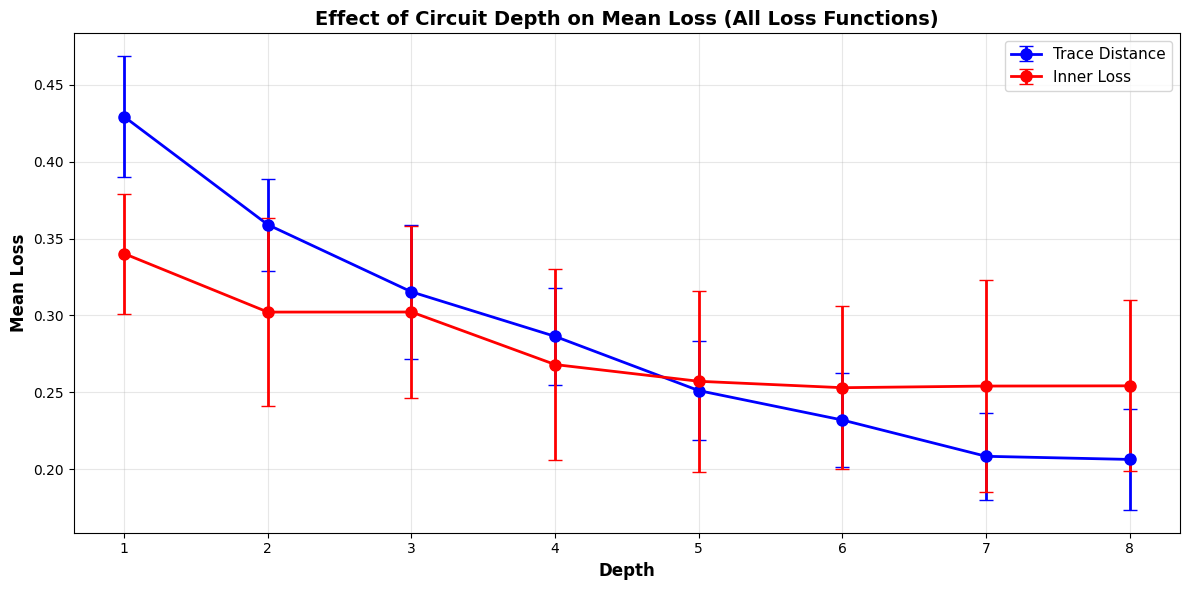

Mean Loss Summary:

TRACE_DISTANCE:
  Depth 1: 0.429131 ± 0.039410 (n=20)
  Depth 2: 0.358975 ± 0.029853 (n=20)
  Depth 3: 0.315352 ± 0.043652 (n=20)
  Depth 4: 0.286420 ± 0.031355 (n=20)
  Depth 5: 0.251223 ± 0.032020 (n=20)
  Depth 6: 0.232101 ± 0.030520 (n=20)
  Depth 7: 0.208539 ± 0.028204 (n=20)
  Depth 8: 0.206503 ± 0.032862 (n=20)

INNER_LOSS:
  Depth 1: 0.340174 ± 0.039069 (n=13)
  Depth 2: 0.302219 ± 0.061217 (n=20)
  Depth 3: 0.302265 ± 0.055813 (n=20)
  Depth 4: 0.268124 ± 0.062125 (n=20)
  Depth 5: 0.257267 ± 0.058731 (n=20)
  Depth 6: 0.253098 ± 0.052896 (n=20)
  Depth 7: 0.254161 ± 0.069068 (n=20)
  Depth 8: 0.254311 ± 0.055580 (n=20)


In [2]:
# Visualize Mean Loss vs Depth for all loss types
import matplotlib.pyplot as plt
import numpy as np

depths_list = sorted([d for d in depth_loss_results.keys() if depth_loss_results[d]])

plt.figure(figsize=(12, 6))

# colors = {'trace_distance': 'blue', 'hilbert_schmidt': 'green', 'inner_loss': 'red'}
colors = {'trace_distance': 'blue', 'inner_loss': 'red'}

for loss_type in loss_types:
    losses = []
    stds = []
    valid_depths = []
    
    for d in depths_list:
        if loss_type in depth_loss_results[d]:
            losses.append(depth_loss_results[d][loss_type]['mean_loss'])
            stds.append(depth_loss_results[d][loss_type]['std_loss'])
            valid_depths.append(d)
    
    if losses:
        plt.errorbar(valid_depths, losses, yerr=stds, marker='o', linestyle='-', 
                    linewidth=2, markersize=8, capsize=5, 
                    label=loss_type.replace('_', ' ').title(),
                    color=colors[loss_type])

plt.xlabel('Depth', fontsize=12, fontweight='bold')
plt.ylabel('Mean Loss', fontsize=12, fontweight='bold')
plt.title('Effect of Circuit Depth on Mean Loss (All Loss Functions)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(depths_list)
plt.tight_layout()
plt.show()

print("Mean Loss Summary:")
for loss_type in loss_types:
    print(f"\n{loss_type.upper()}:")
    for d in depths_list:
        if loss_type in depth_loss_results[d]:
            result = depth_loss_results[d][loss_type]
            print(f"  Depth {d}: {result['mean_loss']:.6f} ± {result['std_loss']:.6f} (n={result['n_runs']})")

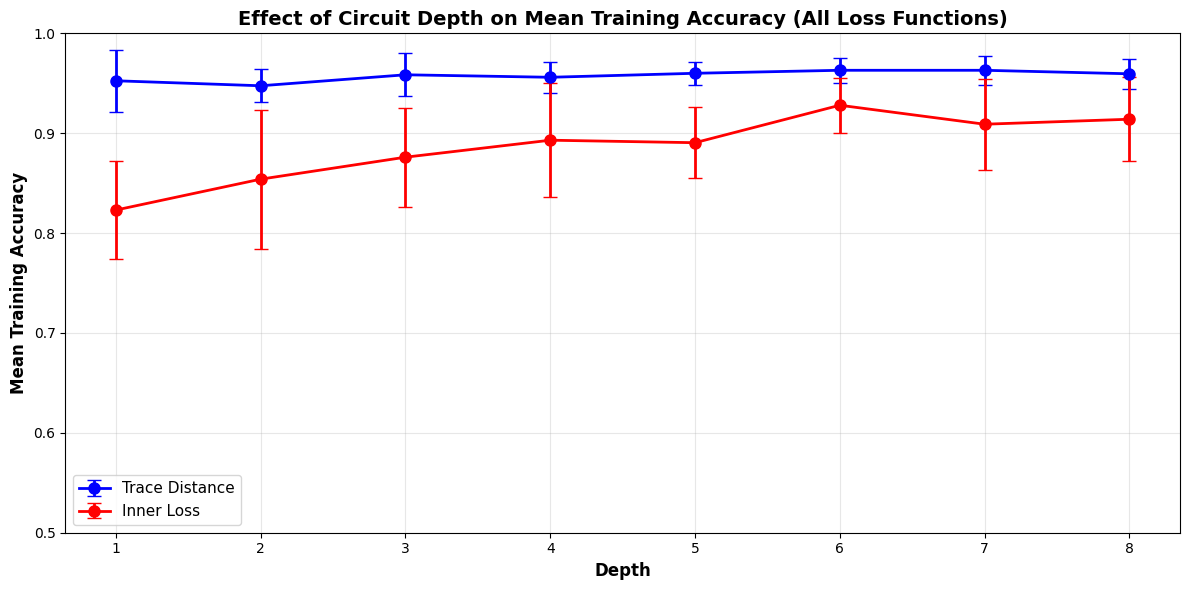


Mean Training Accuracy Summary:

TRACE_DISTANCE:
  Depth 1: 0.9525 ± 0.0310 (n=20)
  Depth 2: 0.9475 ± 0.0167 (n=20)
  Depth 3: 0.9585 ± 0.0215 (n=20)
  Depth 4: 0.9560 ± 0.0156 (n=20)
  Depth 5: 0.9600 ± 0.0114 (n=20)
  Depth 6: 0.9630 ± 0.0127 (n=20)
  Depth 7: 0.9630 ± 0.0145 (n=20)
  Depth 8: 0.9595 ± 0.0150 (n=20)

INNER_LOSS:
  Depth 1: 0.8231 ± 0.0489 (n=13)
  Depth 2: 0.8540 ± 0.0695 (n=20)
  Depth 3: 0.8760 ± 0.0496 (n=20)
  Depth 4: 0.8930 ± 0.0569 (n=20)
  Depth 5: 0.8905 ± 0.0357 (n=20)
  Depth 6: 0.9280 ± 0.0275 (n=20)
  Depth 7: 0.9090 ± 0.0454 (n=20)
  Depth 8: 0.9140 ± 0.0422 (n=20)


In [3]:
# Visualize Mean Training Accuracy vs Depth for all loss types
depths_list = sorted([d for d in depth_loss_results.keys() if depth_loss_results[d]])

plt.figure(figsize=(12, 6))

# colors = {'trace_distance': 'blue', 'hilbert_schmidt': 'green', 'inner_loss': 'red'}
colors = {'trace_distance': 'blue', 'inner_loss': 'red'}

for loss_type in loss_types:
    train_accs = []
    stds = []
    valid_depths = []
    
    for d in depths_list:
        if loss_type in depth_loss_results[d]:
            train_accs.append(depth_loss_results[d][loss_type]['mean_train_acc'])
            stds.append(depth_loss_results[d][loss_type]['std_train_acc'])
            valid_depths.append(d)
    
    if train_accs:
        plt.errorbar(valid_depths, train_accs, yerr=stds, marker='o', linestyle='-', 
                    linewidth=2, markersize=8, capsize=5,
                    label=loss_type.replace('_', ' ').title(),
                    color=colors[loss_type])

plt.xlabel('Depth', fontsize=12, fontweight='bold')
plt.ylabel('Mean Training Accuracy', fontsize=12, fontweight='bold')
plt.title('Effect of Circuit Depth on Mean Training Accuracy (All Loss Functions)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(depths_list)
plt.ylim([0.5, 1.0])
plt.tight_layout()
plt.show()

print("\nMean Training Accuracy Summary:")
for loss_type in loss_types:
    print(f"\n{loss_type.upper()}:")
    for d in depths_list:
        if loss_type in depth_loss_results[d]:
            result = depth_loss_results[d][loss_type]
            print(f"  Depth {d}: {result['mean_train_acc']:.4f} ± {result['std_train_acc']:.4f} (n={result['n_runs']})")

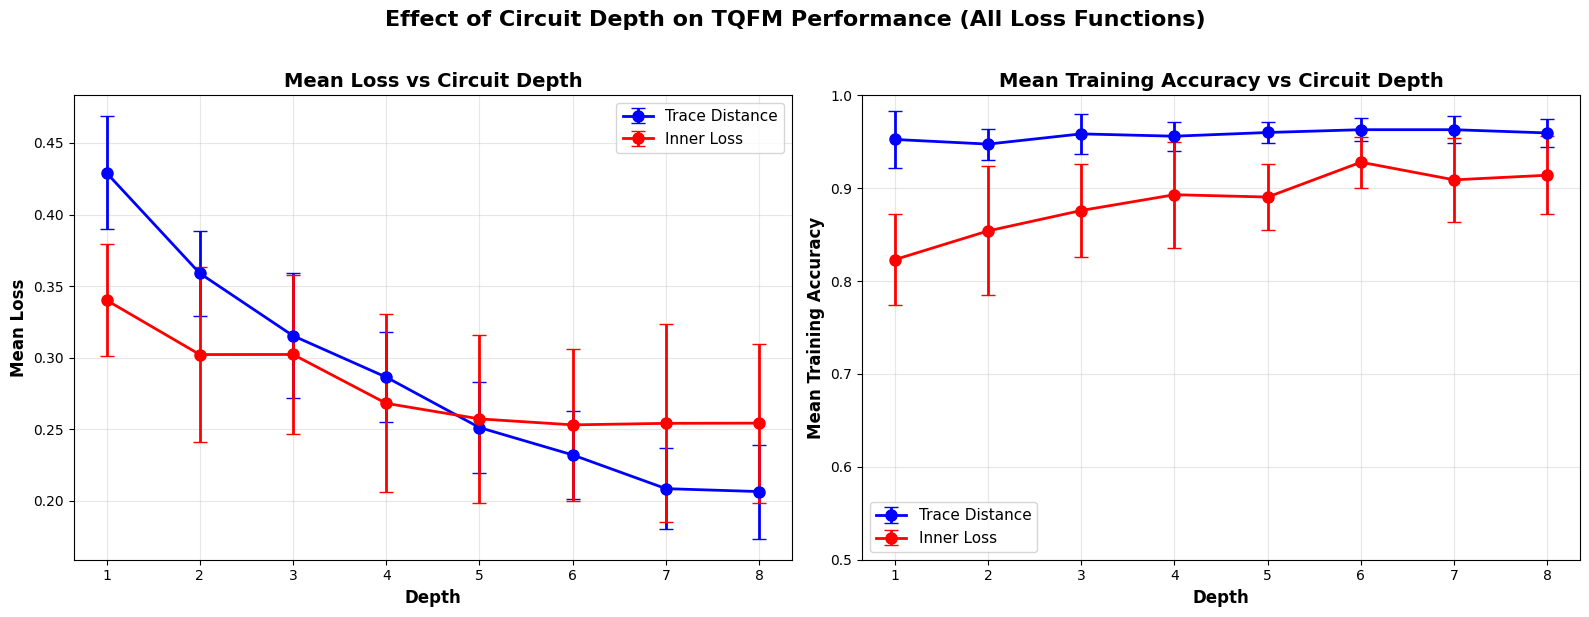

: 

In [ ]:
# Combined visualization: Mean Loss and Mean Accuracy for all loss types
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

depths_list = sorted([d for d in depth_loss_results.keys() if depth_loss_results[d]])
colors = {'trace_distance': 'blue', 'inner_loss': 'red'}

# Left plot: Mean Loss vs Depth
for loss_type in loss_types:
    if loss_type not in colors:
        continue
    
    losses = []
    stds = []
    valid_depths = []
    
    for d in depths_list:
        if loss_type in depth_loss_results[d]:
            losses.append(depth_loss_results[d][loss_type]['mean_loss'])
            stds.append(depth_loss_results[d][loss_type]['std_loss'])
            valid_depths.append(d)
    
    if losses:
        ax1.errorbar(valid_depths, losses, yerr=stds, marker='o', linestyle='-',
                    linewidth=2, markersize=8, capsize=5,
                    label=loss_type.replace('_', ' ').title(),
                    color=colors[loss_type])

ax1.set_xlabel('Depth', fontsize=12, fontweight='bold')
ax1.set_ylabel('Mean Loss', fontsize=12, fontweight='bold')
ax1.set_title('Mean Loss vs Circuit Depth', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(depths_list)

# Right plot: Mean Training Accuracy vs Depth
for loss_type in loss_types:
    if loss_type not in colors:
        continue
    train_accs = []
    stds = []
    valid_depths = []
    
    for d in depths_list:
        if loss_type in depth_loss_results[d]:
            train_accs.append(depth_loss_results[d][loss_type]['mean_train_acc'])
            stds.append(depth_loss_results[d][loss_type]['std_train_acc'])
            valid_depths.append(d)
    
    if train_accs:
        ax2.errorbar(valid_depths, train_accs, yerr=stds, marker='o', linestyle='-',
                    linewidth=2, markersize=8, capsize=5,
                    label=loss_type.replace('_', ' ').title(),
                    color=colors[loss_type])

ax2.set_xlabel('Depth', fontsize=12, fontweight='bold')
ax2.set_ylabel('Mean Training Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Mean Training Accuracy vs Circuit Depth', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(depths_list)
ax2.set_ylim([0.5, 1.0])

plt.suptitle('Effect of Circuit Depth on TQFM Performance (All Loss Functions)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()